In [ ]:
from sklearn.cluster import KMeans
from helpers import *
from gbd_core.api import GBD
from bitarray import bitarray
import numpy as np

import pickle

features = get_available_features()

seed = 0
def clusterbestlist(n_labels=10, k_config=10, seed=0):
    with GBD([ '/home/raphael-zipperer/Uni/BA/database/base.db', '/home/raphael-zipperer/Uni/BA/database/meta.db' ]) as gbd:
        data = gbd.query('(track=main_2023 or track=main_2024) and minisat1m!=yes', resolve=features + ["family"])
        
        # Identify families with less than 5 entries
        family_counts = data['family'].value_counts()
        families_to_replace = family_counts[family_counts < 5].index
    
        # Replace the family label with "rest" for these families
        data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)
    
        data_train, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])
    
        hashes_by_family = data_train.groupby("family")["hash"].apply(list).to_dict()
      
        famindeces = {}
        for fam, hashes in hashes_by_family.items():
            indeces = bestcluster(hashes, k_config).index.tolist()
        
            famindeces[fam] = indeces.copy()
        
        fam_bitarrays = {}
        for fam, indeces in famindeces.items():
            ba = bitarray(40)
            ba.setall(0)
            for index in indeces:
                ba[index] = 1
            fam_bitarrays[fam] = ba
    
        
        bitarrays_list = list(fam_bitarrays.values())
        bitarrays_matrix = np.array([ba.tolist() for ba in bitarrays_list])

        kmeans = KMeans(n_clusters=n_labels, random_state=seed).fit(bitarrays_matrix)
        clusters = kmeans.labels_

        data_train['cluster'] = -1

        # Extract family labels back from the resulting cluster list
        #clustered_families = {i: [] for i in range(n_labels)}
        

        for fam, cluster in zip(fam_bitarrays.keys(), clusters):
            #clustered_families[cluster].append(fam)
            data_train.loc[data_train['family'] == fam, 'cluster'] = cluster
    
        # Collect the corresponding hashes to each cluster
        #clustered_hashes = {i: [] for i in range(n_labels)}
        #for cluster, families in clustered_families.items():
        #    for fam in families:
        #        clustered_hashes[cluster].extend(hashes_by_family[fam])
    
        #best_configurations = {}
        #for cluster, hashes in clustered_hashes.items():
        #    best_configurations[cluster] = getBest(hashes)
    #
        #configurations_to_families = {}
        #for cluster, config in best_configurations.items():
        #    if config not in configurations_to_families:
        #        configurations_to_families[config] = []
        #    configurations_to_families[config].extend(clustered_families[cluster])
    
        #with open('configurations_to_families.txt', 'w') as f:
        #    for config, families in configurations_to_families.items():
        #        f.write(f'Configuration: {config}, Families: {", ".join(families)}\n')

        indeces = minhitset(data_train, k_config, seed=seed, target="cluster")

        df = pd.read_csv("top40.csv")
        df = df.groupby('configuration')['time'].sum()
        configs = df.iloc[indeces].index.tolist()
        
        data_train['config'] = "Default"
        for cluster in set(clusters):
            cluster_hashes = data_train.loc[data_train['cluster'] == cluster, 'hash'].tolist()
            data_train.loc[data_train['cluster'] == cluster, 'config'] = getBest(cluster_hashes, configs)
        
        #for config, fams in configurations_to_families.items():
        #    configs.append(config)
        #    famlist.append(fams)
        
        #data_train['index'] = -1
        #for i, sublist in enumerate(famlist):
        #    data_train.loc[data_train['family'].isin(sublist), 'index'] = configs[i]
        
        rf = RandomForestClassifier()
    
        rf.fit(data_train[features], data_train["config"])
    
        insts = data_test['hash'].tolist()
        y_pred = rf.predict(data_test[features])
    
        predictions_df = pd.DataFrame(list(zip(data_test["hash"], y_pred)), columns=["hash", "predicted_index"])
    
        default_sum = getDefault(insts)
        virtual_sum = getVirtual(insts, configs)
        eval_sum = evalConfigPredict(predictions_df)
    
        return {
                'Default': default_sum,
                'Virtual': virtual_sum,
                'Eval': eval_sum
            }

results = []
for k in range(17,20):
    partial = []
    for i in range(20):
        partial.append(clusterbestlist(n_labels=k, seed=i))
    results.append(partial)
    with open('bestlistminhit/{}labels.pkl'.format(k), 'wb') as f:
        pickle.dump(partial, f)

KeyboardInterrupt: 

20


/home/raphael-zipperer/Uni/BA/classifier/classifier/helpers.py:251: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


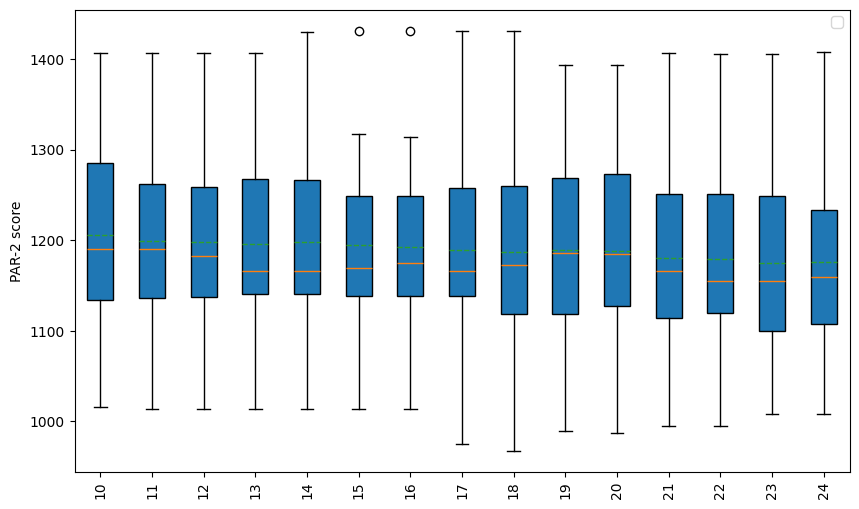

[1206.0596897798935,
 1198.8790877116355,
 1197.3370984630365,
 1195.986393943429,
 1198.2835628420899,
 1194.889375079933,
 1192.4444755412246,
 1188.6294260991247,
 1186.5095018571144,
 1189.3375916981383,
 1187.719411148523,
 1179.644322209217,
 1178.7340910342964,
 1174.4352154620385,
 1176.1426793514897]

In [1]:
import pickle
from helpers import *

results = []
for i in range(10,25):
    with open('bestlistminhit/{}labels.pkl'.format(i), 'rb') as f:
        results.append(pickle.load(f))

print(len(results[0]))
compareModels(results, [i for i in range(10,25)], title="")